In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import matplotlib.pyplot as plt
import math
from variable_functions import *
import os
import dask_awkward as dak
import scipy

/tmp/ipykernel_1776600/3549297373.py:8: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  import coffea.nanoevents.methods.vector as vector


In [2]:
warnings.filterwarnings("ignore", module="coffea.*")
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "invalid value")

In [3]:
files = os.listdir('/project01/ndcms/cmoore24/samples/hbb/')[:2]

In [4]:
files

['nano_mc2017_1-1.root', 'nano_mc2017_1-2.root']

In [5]:
events = NanoEventsFactory.from_root(
    [{'/project01/ndcms/cmoore24/samples/hbb/' + i: "/Events"} for i in files],
    delayed=True,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "Hbb"},
).events()

In [6]:
events['PFCands', 'pt'] = (
    events.PFCands.pt
    * events.PFCands.puppiWeight
)

In [7]:
cut_to_fix_softdrop = (ak.num(events.FatJet.constituents.pf, axis=2) > 0)
events = events[ak.all(cut_to_fix_softdrop, axis=1)]

In [10]:
genhiggs = events.GenPart[
    (events.GenPart.pdgId == 25)
    & events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
]
parents = events.FatJet.nearest(genhiggs, threshold=0.2)
higgs_jets = ~ak.is_none(parents, axis=1)

fatjetSelect = (
            (events.FatJet.pt > 400)
            #& (events.FatJet.num_subjets >= 3)
            & (abs(events.FatJet.eta) < 2.4)
            & (events.FatJet.msoftdrop > 40)
            & (events.FatJet.msoftdrop < 200)
            & (higgs_jets)
        )

events["goodjets"] = events.FatJet[fatjetSelect]
mask = ~ak.is_none(ak.firsts(events.goodjets))
events = events[mask]
ecfs = {}
for n in range(2,3):
    for v in range(1, int(scipy.special.binom(n, 2))+1):
        for b in range(5, 10, 5):
            ecf_name = f'{v}e{n}^{b/10}'
            ecfs[ecf_name] = make_ecf(events.goodjets, n=n, v=v, b=b/10)
events["ecfs"] = ak.zip(ecfs)
# cut = (ak.num(uncut_events.FatJet.constituents.pf, axis=2) > 0)
# events = uncut_events[ak.all(cut, axis=1)]

In [12]:
events.ecfs.compute()

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


<Array [{'1e2^0.5': 0.207}, {...}, ..., {...}] type='1495 * {"1e2^0.5": flo...'>

In [35]:
a = events.goodjets[[x for x in ak.fields(events.goodjets) if x == 'area']]

In [36]:
a.compute()

<Array [[{area: 1.96}], [{...}], ..., [{...}]] type='261 * var * {area: flo...'>

In [61]:
events = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/samples/hbb/' + files[0]: "/Events"},
    delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "Hbb"},
).events()

In [62]:
events['PFCands', 'pt'] = (
    events.PFCands.pt
    * events.PFCands.puppiWeight
)

In [63]:
cut_to_fix_softdrop = (ak.num(events.FatJet.constituents.pf, axis=2) > 0)
events = events[ak.all(cut_to_fix_softdrop, axis=1)]

In [64]:
genhiggs = events.GenPart[
    (events.GenPart.pdgId == 25)
    & events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
]
parents = events.FatJet.nearest(genhiggs, threshold=0.2)
higgs_jets = ~ak.is_none(parents, axis=1)

In [65]:
fatjetSelect = (
            (events.FatJet.pt > 400)
            #& (events.FatJet.num_subjets >= 3)
            & (abs(events.FatJet.eta) < 2.4)
            & (events.FatJet.msoftdrop > 40)
            & (events.FatJet.msoftdrop < 200)
            & (higgs_jets)
        )

In [66]:
events["goodjets"] = events.FatJet[fatjetSelect]

In [67]:
mask = ~ak.is_none(ak.firsts(events.goodjets))

In [68]:
events = events[mask]

In [10]:
a = os.listdir('/project01/ndcms/cmoore24/skims/test/hbb/')[:2]

In [12]:
dak.from_parquet(['/project01/ndcms/cmoore24/skims/test/hbb/' + i for i in a])

dask.awkward<from-parquet, npartitions=2>

In [13]:
a = ak.from_parquet('/project01/ndcms/cmoore24/skims/test/hbb2/')

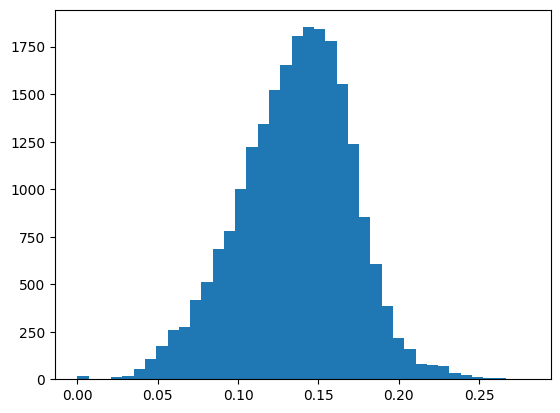

In [24]:
plt.hist(a.goodjets.u1, bins=40)
#plt.yscale('log')
plt.show()